<a href="https://colab.research.google.com/github/XingxinHE/FinalThesis_DL-GA/blob/master/Stage_3_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
import os

Mounted at /content/gdrive


In [4]:
os.chdir("/content/gdrive/My Drive/Final Thesis/data/stage3")

## Data Preparation

### Loading Input

In [5]:
train_x = pd.read_csv('605_coord.csv', index_col=0)
train_x.drop(columns=list('2568'), axis=1, inplace=True)

In [6]:
train_x.shape

(605, 5)

In [7]:
train_x.head()

,0,1,3,4,7
0,40.0,35.0,30.0,20.0,35.0
1,40.0,40.0,40.0,15.0,35.0
2,30.0,30.0,40.0,20.0,20.0
3,10.0,40.0,40.0,20.0,25.0
4,35.0,40.0,30.0,10.0,30.0


In [8]:
test_x = pd.read_csv('10_coord.csv', index_col=0)
test_x.drop(columns=list('2568'), axis=1, inplace=True)

In [9]:
test_x.shape

(10, 5)

In [10]:
test_x.tail()

,0,1,3,4,7
5,30.0,40.0,15.0,10.0,20.0
6,40.0,35.0,35.0,20.0,30.0
7,35.0,40.0,25.0,15.0,20.0
8,25.0,35.0,30.0,15.0,15.0
9,20.0,40.0,10.0,10.0,35.0


In [11]:
train_test = pd.concat([train_x, test_x])
train_test

,0,1,3,4,7
0,40.0,35.0,30.0,20.0,35.0
1,40.0,40.0,40.0,15.0,35.0
2,30.0,30.0,40.0,20.0,20.0
3,10.0,40.0,40.0,20.0,25.0
4,35.0,40.0,30.0,10.0,30.0
...,...,...,...,...,...
5,30.0,40.0,15.0,10.0,20.0
6,40.0,35.0,35.0,20.0,30.0
7,35.0,40.0,25.0,15.0,20.0
8,25.0,35.0,30.0,15.0,15.0


### Loading output

In [51]:
train_y = pd.read_csv('optimal_605.csv', index_col=0)
train_y.shape

(605, 2)

In [52]:
train_y.head()

,bar_orders,weight
0,"2.83810870599491, 0.6358100457084843, 1.591918...",103.451705
1,"0.8345770523120521, 0.9756589343833298, 2.6056...",111.959005
2,"2.957788117293222, 2.724991772207066, 1.764825...",119.747432
3,"3.438750738336929, 0.0004908677138951938, 1.38...",101.092659
4,"0.2559104201266245, 1.5397079930733486, 1.6019...",111.386501


In [53]:
test_y = pd.read_csv('testing_10.csv', index_col=0)
test_y.shape

(10, 2)

In [54]:
#define a function convert np of object to np of float
def f(x):
    return np.array(x.replace('[', '').replace(']', '').replace(',', ' ').split()).astype(float)

In [55]:
train_y = np.array([f(t) for t in train_y['bar_orders']])
train_y = np.floor(train_y)
train_y = train_y.astype(int)
train_y.shape

(605, 220)

In [56]:
train_y

array([[2, 0, 1, ..., 0, 2, 1],
       [0, 0, 2, ..., 2, 0, 1],
       [2, 2, 1, ..., 1, 1, 1],
       ...,
       [0, 1, 3, ..., 0, 3, 1],
       [1, 1, 2, ..., 0, 1, 2],
       [2, 3, 2, ..., 1, 0, 0]])

In [57]:
test_y = np.array([f(t) for t in test_y['bar_orders']])
test_y = np.floor(test_y)
test_y = test_y.astype(int)
test_y.shape

(10, 220)

In [58]:
test_y

array([[1, 0, 2, ..., 0, 0, 2],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 3, ..., 1, 0, 0],
       ...,
       [2, 0, 1, ..., 2, 0, 2],
       [2, 2, 1, ..., 0, 0, 2],
       [0, 1, 2, ..., 2, 1, 2]])

### One-hot coding input

In [24]:
intput_features = len(train_x.columns)
intput_features

5

In [25]:
sorted(pd.unique(train_test[train_test.columns].values.ravel('K')))

[10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0]

In [26]:
intput_features_possibilities = sorted(pd.unique(train_test[train_test.columns].values.ravel('K')))

In [27]:
intput_features_possibilities = [int(i) for i in intput_features_possibilities]
intput_features_possibilities

[10, 15, 20, 25, 30, 35, 40]

In [29]:
intput_features_possibilities_indices = dict((feature, intput_features_possibilities.index(feature)) for feature in intput_features_possibilities)
intput_features_possibilities_indices

{10: 0, 15: 1, 20: 2, 25: 3, 30: 4, 35: 5, 40: 6}

In [37]:
train_x_onehot = np.zeros((len(train_x.index), intput_features, len(intput_features_possibilities)), dtype=np.bool)
test_x_onehot = np.zeros((len(test_x.index), intput_features, len(intput_features_possibilities)), dtype=np.bool)

In [39]:
train_x_onehot.shape

(605, 5, 7)

In [40]:
test_x_onehot.shape

(10, 5, 7)

In [47]:
for i in range(len(train_x.index)):
  for j in range(len(train_x.columns)):
    train_x_onehot[i, j, intput_features_possibilities_indices[train_x.iloc[i,j]]] = 1

In [49]:
for i in range(len(test_x.index)):
  for j in range(len(test_x.columns)):
    test_x_onehot[i, j, intput_features_possibilities_indices[test_x.iloc[i,j]]] = 1

### One-hot coding output

In [ ]:
intput_features = len(train_x.columns)
intput_features

5

In [ ]:
sorted(pd.unique(train_test[train_test.columns].values.ravel('K')))

[10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0]

In [ ]:
intput_features_possibilities = sorted(pd.unique(train_test[train_test.columns].values.ravel('K')))

In [ ]:
intput_features_possibilities = [int(i) for i in intput_features_possibilities]
intput_features_possibilities

[10, 15, 20, 25, 30, 35, 40]

In [ ]:
intput_features_possibilities_indices = dict((feature, intput_features_possibilities.index(feature)) for feature in intput_features_possibilities)
intput_features_possibilities_indices

{10: 0, 15: 1, 20: 2, 25: 3, 30: 4, 35: 5, 40: 6}

In [ ]:
train_x_onehot = np.zeros((len(train_x.index), intput_features, len(intput_features_possibilities)), dtype=np.bool)
test_x_onehot = np.zeros((len(test_x.index), intput_features, len(intput_features_possibilities)), dtype=np.bool)

In [ ]:
train_x_onehot.shape

(605, 5, 7)

In [ ]:
test_x_onehot.shape

(10, 5, 7)

In [ ]:
for i in range(len(train_x.index)):
  for j in range(len(train_x.columns)):
    train_x_onehot[i, j, intput_features_possibilities_indices[train_x.iloc[i,j]]] = 1

In [ ]:
for i in range(len(test_x.index)):
  for j in range(len(test_x.columns)):
    test_x_onehot[i, j, intput_features_possibilities_indices[test_x.iloc[i,j]]] = 1

array([[[False,  True, False, False, False, False, False],
        [False, False, False, False, False, False,  True],
        [False, False, False,  True, False, False, False],
        [False,  True, False, False, False, False, False],
        [False,  True, False, False, False, False, False]],

       [[False, False, False, False,  True, False, False],
        [False, False, False, False,  True, False, False],
        [False, False, False, False, False, False,  True],
        [ True, False, False, False, False, False, False],
        [False, False, False,  True, False, False, False]],

       [[ True, False, False, False, False, False, False],
        [False, False, False, False, False, False,  True],
        [False, False, False, False, False, False,  True],
        [False, False,  True, False, False, False, False],
        [False, False, False, False,  True, False, False]],

       [[False, False, False, False, False,  True, False],
        [False, False, False, False, False, False,

## Initialize Model （Dense,SGD)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=5)) #输入5个
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(220, )) #输出220个

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse',
              optimizer=sgd
              )

history = model.fit(train_x, train_y,
          epochs=1000,
          batch_size=32,
          #validation_data = (x_test, y_test)
          validation_split = 0.2,
          callbacks=[early_stop, tfdocs.modeling.EpochDots()],
          )

Epoch 1/1000
 1/16 [>.............................] - ETA: 0s - loss: 2.4768
Epoch: 0, loss:2.5068,  val_loss:2.4115,  
16/16 [==============================] - 0s 8ms/step - loss: 2.5068 - val_loss: 2.4115
Epoch 2/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.3918 - val_loss: 2.3036
Epoch 3/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2680 - val_loss: 2.1734
Epoch 4/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.1168 - val_loss: 1.9925
Epoch 5/1000
16/16 [==============================] - 0s 3ms/step - loss: 1.9253 - val_loss: 1.7417
Epoch 6/1000
16/16 [==============================] - 0s 3ms/step - loss: 1.6675 - val_loss: 1.4337
Epoch 7/1000
16/16 [==============================] - 0s 3ms/step - loss: 1.4436 - val_loss: 1.1654
Epoch 8/1000
16/16 [==============================] - 0s 3ms/step - loss: 1.2975 - val_loss: 1.0272
Epoch 9/1000
16/16 [==============================] - 0s 3ms/step - loss: 1.2316 - val_loss: 

## Initialize Model (Softmax)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=5)) #输入5个
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(220, activation='softmax')) #输出220个

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
       optimizer='rmsprop',
       metrics=['accuracy']
              )

history = model.fit(train_x, train_y,
          epochs=1000,
          batch_size=32,
          #validation_data = (x_test, y_test)
          validation_split = 0.2,
          callbacks=tfdocs.modeling.EpochDots(),
          )

Epoch 1/1000
 1/16 [>.............................] - ETA: 0s - loss: 1543.4539 - accuracy: 0.0000e+00
Epoch: 0, accuracy:0.0062,  loss:1532.5759,  val_accuracy:0.0165,  val_loss:1522.6447,  
16/16 [==============================] - 0s 10ms/step - loss: 1532.5759 - accuracy: 0.0062 - val_loss: 1522.6447 - val_accuracy: 0.0165
Epoch 2/1000
16/16 [==============================] - 0s 4ms/step - loss: 1561.4824 - accuracy: 0.0041 - val_loss: 1539.9374 - val_accuracy: 0.0000e+00
Epoch 3/1000
16/16 [==============================] - 0s 4ms/step - loss: 1612.6146 - accuracy: 0.0083 - val_loss: 1569.3284 - val_accuracy: 0.0000e+00
Epoch 4/1000
16/16 [==============================] - 0s 4ms/step - loss: 1681.5049 - accuracy: 0.0041 - val_loss: 1615.4117 - val_accuracy: 0.0083
Epoch 5/1000
16/16 [==============================] - 0s 4ms/step - loss: 1794.6479 - accuracy: 0.0062 - val_loss: 1677.1671 - val_accuracy: 0.0083
Epoch 6/1000
16/16 [==============================] - 0s 4ms/step - loss

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 64)                384       
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 220)               14300     
Total params: 18,844
Trainable params: 18,844
Non-trainable params: 0
_________________________________________________________________


## Prediction

In [ ]:
test_predictions = model.predict(test_x)

In [ ]:
test_predictions.shape

(10, 220)

In [ ]:
test_predictions = pd.DataFrame(test_predictions)

In [ ]:
test_predictions

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219
0,1.297256,1.189361,1.132536,1.302260,1.169439,1.252599,1.184923,1.103148,1.212186,1.266332,1.232296,1.308228,1.209856,1.217574,1.318938,1.273919,1.206169,1.248824,1.181691,1.110913,1.253744,1.262384,1.140153,1.252629,1.164091,1.189390,1.206530,1.194076,1.282547,1.289580,1.080059,1.260352,1.149923,1.124912,1.232630,1.179067,1.298462,1.258388,1.173152,1.192249,...,1.186101,1.213589,1.196523,1.168819,1.234037,1.253356,1.228481,1.280059,1.203528,1.197553,1.206674,1.199048,1.267492,1.189786,1.162275,1.096708,1.123636,1.122166,1.167188,1.184142,1.243164,1.269007,1.231575,1.088177,1.230852,1.173689,1.297969,1.060149,1.313246,1.228178,1.331168,1.276224,1.211964,1.215018,1.194930,1.211493,1.153677,1.117755,1.139819,1.260445
1,1.327115,1.142003,1.163430,1.270357,1.130347,1.195816,1.120640,1.103970,1.219769,1.181871,1.223658,1.332418,1.186794,1.183458,1.272051,1.241971,1.225142,1.268425,1.194432,1.156589,1.241038,1.224666,1.096950,1.196099,1.143495,1.153259,1.142155,1.184550,1.233270,1.261168,1.058254,1.175549,1.140278,1.085573,1.213219,1.178857,1.240433,1.221825,1.199255,1.149395,...,1.166261,1.223579,1.183960,1.156094,1.273979,1.254469,1.220472,1.265917,1.220980,1.229691,1.223691,1.149421,1.274404,1.186850,1.141265,1.103994,1.163800,1.108644,1.147498,1.130603,1.210496,1.255641,1.193401,1.101594,1.231972,1.238052,1.253018,1.078172,1.244361,1.220966,1.259896,1.267038,1.210528,1.207428,1.189874,1.149068,1.092033,1.119489,1.134648,1.242739
2,1.366864,1.169779,1.198631,1.307396,1.224856,1.279887,1.173073,1.178774,1.306439,1.273728,1.270337,1.370119,1.241489,1.243023,1.352678,1.315099,1.209998,1.317940,1.235593,1.191536,1.314927,1.270892,1.169984,1.285327,1.196757,1.216472,1.236964,1.222694,1.320738,1.352087,1.105927,1.212589,1.198550,1.139443,1.264057,1.224962,1.349521,1.282406,1.275052,1.216791,...,1.208878,1.293635,1.222590,1.228574,1.291061,1.304609,1.294303,1.308733,1.272877,1.211273,1.273798,1.221198,1.302945,1.196652,1.176506,1.155794,1.197688,1.086556,1.173920,1.172170,1.291111,1.293598,1.256632,1.163860,1.207528,1.254616,1.293296,1.101834,1.301377,1.269699,1.353710,1.314361,1.261687,1.249773,1.291845,1.195573,1.164096,1.161016,1.224749,1.289310
3,1.329310,1.181041,1.167684,1.241564,1.142548,1.229880,1.143544,1.101485,1.207441,1.264979,1.194637,1.278807,1.233290,1.198820,1.273201,1.283649,1.220910,1.250398,1.191236,1.181810,1.309355,1.235784,1.168283,1.244176,1.204378,1.240948,1.191147,1.180547,1.277906,1.260639,1.084857,1.257480,1.110626,1.099000,1.229652,1.186714,1.333432,1.272419,1.170872,1.136378,...,1.194533,1.237542,1.168100,1.184326,1.294242,1.292353,1.222468,1.251635,1.241282,1.225189,1.179232,1.191870,1.280598,1.173245,1.180964,1.166436,1.179450,1.090128,1.187284,1.175694,1.220266,1.261718,1.210505,1.163747,1.208758,1.185177,1.252824,1.120215,1.278781,1.285496,1.326240,1.304006,1.195950,1.172507,1.202718,1.192876,1.143127,1.178923,1.151727,1.258866
4,1.285454,1.166745,1.124959,1.274007,1.150614,1.217064,1.141791,1.098535,1.208206,1.254137,1.209977,1.318646,1.180807,1.209292,1.310155,1.287302,1.148256,1.240628,1.183448,1.109997,1.248156,1.218959,1.173167,1.242317,1.151035,1.203702,1.172203,1.172990,1.302207,1.273484,1.068389,1.223353,1.141722,1.124560,1.203342,1.152227,1.295139,1.234600,1.173619,1.175376,...,1.180207,1.220034,1.161146,1.158836,1.211117,1.238383,1.218625,1.259559,1.186143,1.167219,1.193230,1.186719,1.253057,1.171997,1.132582,1.098605,1.125008,1.083232,1.128017,1.166911,1.234400,1.260356,1.210716,1.079162,1.205614,1.137698,1.281618,1.054016,1.303092,1.224458,1.306099,1.237522,1.196378,1.165671,1.194251,1.198773,1.105454,1.106809,1.151457,1.252445
5,1.302743,1.187342,1.132481,1.284718,1.158201,1.225252,1.165443,1.070200,1.143733,1.251778,1.1

In [ ]:
test_predictions * train_y_test_y_stats['std'] + train_y_test_y_stats['mean']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219
0,2.628733,2.308827,2.281555,2.619576,2.290637,2.387015,2.269662,2.280428,2.550808,2.413184,2.429984,2.587444,2.400849,2.378126,2.565844,2.525153,2.369223,2.509301,2.348417,2.332151,2.500804,2.452207,2.199232,2.418787,2.350722,2.319492,2.308131,2.337476,2.551229,2.612617,2.125126,2.360901,2.253608,2.122853,2.476902,2.268956,2.558829,2.428721,2.400394,2.312306,...,2.418033,2.435334,2.373111,2.464767,2.441807,2.508824,2.377651,2.488770,2.401070,2.415385,2.357364,2.370675,2.508624,2.351369,2.279599,2.209681,2.250709,2.159618,2.214695,2.345911,2.452912,2.461107,2.439569,2.189150,2.434983,2.254537,2.519381,2.185282,2.500601,2.427163,2.607009,2.562439,2.502143,2.331126,2.368241,2.323990,2.215729,2.201903,2.321458,2.430239
1,2.688621,2.327542,2.287974,2.595419,2.352269,2.388644,2.266447,2.276934,2.606352,2.473355,2.425833,2.650512,2.357382,2.440268,2.582072,2.522901,2.417977,2.573590,2.366508,2.329349,2.526825,2.499411,2.251157,2.453767,2.371553,2.344712,2.305493,2.372750,2.616004,2.603236,2.191947,2.421958,2.257647,2.140655,2.470683,2.338836,2.567429,2.478099,2.475107,2.316432,...,2.455583,2.482214,2.362702,2.451276,2.508717,2.531386,2.433935,2.539505,2.378102,2.408430,2.439497,2.414135,2.500997,2.384116,2.265472,2.274704,2.236005,2.172168,2.298446,2.323144,2.519212,2.486149,2.443498,2.250358,2.410727,2.317104,2.519462,2.232438,2.480605,2.374739,2.574420,2.593884,2.537404,2.364128,2.397650,2.305927,2.243525,2.269905,2.407200,2.488512
2,2.681221,2.362780,2.307868,2.650259,2.327815,2.437772,2.314506,2.325528,2.585402,2.434379,2.447038,2.661682,2.422856,2.449665,2.567882,2.534542,2.418365,2.558234,2.391165,2.360056,2.514274,2.492912,2.213658,2.475950,2.421412,2.333884,2.353368,2.384061,2.629268,2.627203,2.192982,2.406244,2.271990,2.172765,2.536330,2.332006,2.611233,2.433477,2.437378,2.321816,...,2.485378,2.483913,2.396026,2.499976,2.496846,2.552048,2.402235,2.545511,2.419465,2.448797,2.411865,2.385369,2.528933,2.354372,2.291564,2.253263,2.302175,2.216849,2.245082,2.367999,2.530126,2.516567,2.429734,2.253857,2.449277,2.289021,2.547288,2.235298,2.539273,2.436055,2.664647,2.605583,2.577544,2.385488,2.400878,2.368778,2.238636,2.213926,2.373105,2.466803
3,2.731391,2.356005,2.324149,2.667740,2.358357,2.455835,2.324040,2.342363,2.577667,2.438117,2.476028,2.694395,2.418649,2.465576,2.533845,2.564945,2.443647,2.531897,2.415156,2.384091,2.548829,2.467165,2.242693,2.455238,2.396961,2.332330,2.351869,2.383345,2.610631,2.631703,2.229944,2.413333,2.250221,2.183137,2.574415,2.314832,2.612242,2.472943,2.464615,2.330389,...,2.474983,2.480676,2.401732,2.490711,2.500479,2.558294,2.409542,2.578413,2.392083,2.452992,2.442916,2.420330,2.511117,2.373852,2.330232,2.284878,2.263687,2.215357,2.266837,2.356448,2.524024,2.512902,2.454167,2.238013,2.428007,2.298153,2.539598,2.157871,2.524069,2.408281,2.625889,2.621409,2.578142,2.378295,2.394969,2.359993,2.247559,2.238639,2.412806,2.485888
4,2.664892,2.320478,2.305416,2.611919,2.283757,2.402112,2.298400,2.276627,2.531204,2.409598,2.433290,2.600818,2.404902,2.427361,2.563756,2.515672,2.370514,2.506275,2.361457,2.310880,2.480618,2.449144,2.191924,2.418680,2.363302,2.305907,2.310084,2.358118,2.557789,2.597478,2.160092,2.367962,2.238756,2.135798,2.487470,2.286126,2.563347,2.425395,2.413856,2.298316,...,2.431139,2.447347,2.366244,2.462976,2.428822,2.518550,2.388343,2.498611,2.379842,2.410382,2.390763,2.355520,2.489175,2.329206,2.261226,2.230296,2.255379,2.195686,2.230423,2.354364,2.471234,2.480339,2.414530,2.214002,2.408349,2.254142,2.527125,2.188918,2.512064,2.417259,2.599769,2.569554,2.508104,2.325130,2.377856,2.340196,2.218839,2.211272,2.338783,2.438032
5,2.639735,2.317055,2.302321,2.622239,2.298635,2.392957,2.273449,2.323811,2.525311,2.398386,2.4

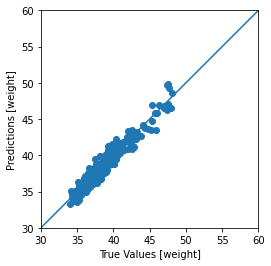

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(weight_pred, test_weight_label)
plt.xlabel('True Values [weight]')
plt.ylabel('Predictions [weight]')
lims = [30, 60]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
test_weight_label

141     49.664072
178     46.876165
180     46.752680
188     49.893984
207     46.951447
          ...    
2527    34.756029
2528    35.064065
2536    36.279261
2541    34.114205
2547    38.539278
Name: weight, Length: 420, dtype: float64

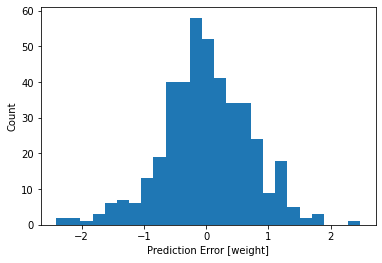

In [ ]:
error = weight_pred.flatten() - test_weight_label
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [weight]")
_ = plt.ylabel("Count")

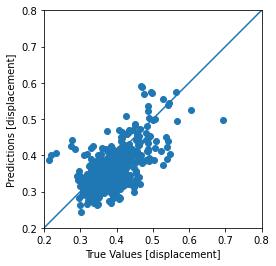

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(displacement_pred, test_displacement_label)
plt.xlabel('True Values [displacement]')
plt.ylabel('Predictions [displacement]')
lims = [0.2, 0.8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

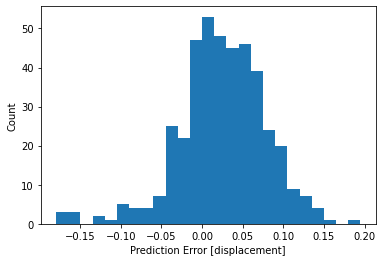

In [ ]:
error = displacement_pred.flatten() - test_displacement_label
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [displacement]")
_ = plt.ylabel("Count")

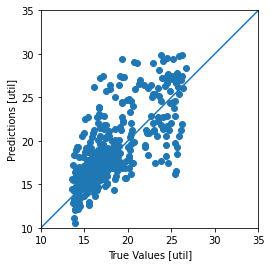

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(util_pred, test_util_label)
plt.xlabel('True Values [util]')
plt.ylabel('Predictions [util]')
lims = [10, 35]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

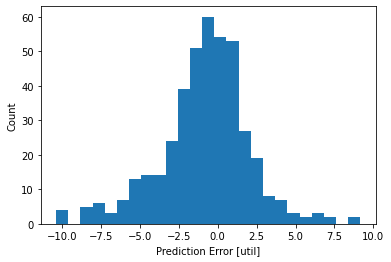

In [ ]:
error = util_pred.flatten() - test_util_label
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [util]")
_ = plt.ylabel("Count")